# Molecular Vibrations

:::{admonition} **What you need to know**
:class: note

- **Quantization of vibrations in molecules.** Vibrational degrees of freedom are quantized in molecules. This which implications for infrared and raman spectroscopies. 
- **Existence of Selection rules.** Not all vibrational transitions are observed. Quantum mechanics predicts that for transition to occur the trasnition probability needs to be non zero which is quantified via transition dipole moment.  
- **Effects of unharmonicity.** Harmonic osccilator approximation captures the dominant transition frequency but is not fully accurate becasue harmonic shape of the potential descrimed the vicinity of potential energy minima which tends to become less accurate for excited vibrational states of molecules. 
:::

### Harmonic Oscillator approximation

- First let us write harmonic oscillator energies in a format used for spectroscopic analysis. This means converting to wavenumber units $\tilde{\nu}=\frac{1}{\lambda}$:

:::{admonition} **Harmonic oscillator and spectroscopuc units**
:class: important

$${\tilde{E}_v = \frac{E_v}{hc} = \tilde{\nu}\left(v + \frac{1}{2}\right)}$$

$${\Delta \tilde{ E_v} } = \tilde{ E}_{v+1} - \tilde{ E}_{v}  = \tilde{\nu}$$

$$\tilde{\nu} = \frac{1}{2\pi c}\sqrt{\frac{k}{\mu}}$$

- **The vibrational quantum number**  $v=0,1,2,...$ 
- **Reduced mass of the diatomic molecule** $\mu$. 
- **Spring constant k** measures strength of bonds
- **$\tilde{\nu}$ frequency of photon (equal to freq of mol vibrations) $cm^{-1}$ units.**
:::

- Note that $v$ and $\nu$ look very similar but have different meaning!  
- A typical value for vibrational frequency would be around  $500 - 4000cm^{-1}$. Small values are associated with weak bonds whereas strong bonds have larger vibrational frequencies.

:::{admonition} **Example**
:class: note

A strong absorption of infrared radiation is observed for $^1H^{35}Cl$ at $2991 cm^{-1}$.

- Calculate the force constant k for this molecule
- By what factor do you expect this frequency to shift if deuterium is substituted for hydrogen in this molecule? The force constant is unaffected by this substitution.
:::

:::{admonition} **Solution**
:class: dropdown

- **part a**

$$\tilde{\nu} = \frac{1}{2\pi c}\sqrt{\frac{k}{\mu}}$$


$$k = \Big(2\pi c \tilde{\nu}\Big)^2\cdot \mu=516 N \cdot m^{-1}$$

- **part b**

$$\frac{\nu_{DCl}}{\nu_{HCL}}=\Big(\frac{\mu_{HCl}}{\mu_{DCL}}\Big)^{1/2}=0.717$$
:::



### Beyond the Harmonic Approximation

- The harmonic potential is an approximation that does not allow for molecular dissociation, making it an unrealistic model when far from equilibrium geometry. The harmonic potential is expressed as:

  $$E(R) = \frac{1}{2}k(R - R_e)^2$$

  Here, $k$ is the *force constant*, $R_e$ is the *equilibrium bond length*, and $R$ is the distance between the two atoms. 

- The true potential energy curve, however, can be derived from theoretical calculations or, to some extent, from spectroscopic experiments. Unlike the harmonic potential, this curve has a complex shape, making it challenging to solve the nuclear Schrödinger equation exactly. 

- The harmonic approximation can be understood as a *Taylor series expansion* around $R_e$:

  $$E(R) = E(R_e) + \left(\frac{dE}{dR}\right)_{R = R_e}(R - R_e) + \frac{1}{2}\left(\frac{d^2E}{dR^2}\right)_{R = R_e}(R - R_e)^2 + \dots$$

:::{figure-md} markdown-fig
<img src="./images/De.png" alt="Comparison of Harmonic and Morse Potentials" class="bg-primary mb-1" width="300px">

It is important to distinguish between two types of dissociation energies: the **equilibrium dissociation energy** $D_e$ and the **spectroscopic dissociation energy** $D_0$. Shown are the harmonic and Morse potentials for comparison.
:::

### Morse potential and dissociation energy 

- Morse potential proisde more accurate description for molecular vibrations and predicts dissociation and changing spacing between energy levels. 

$$V(R)=D_e(1-e^{-a(R-R_e)^2})$$

- $D_e$ is measured from the bottom of the potential to the dissociation limit whereas $D_0$ is measured from the lowest vibrational level to the dissociation limit. 

$$D_0 = D_e-\frac{1}{2}h\nu$$

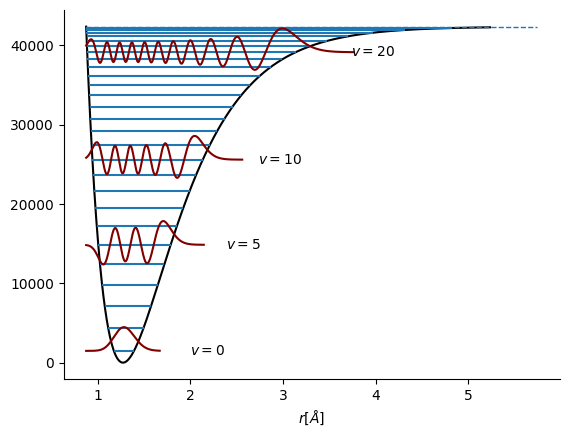

In [ ]:
import numpy as np
from scipy.constants import h, hbar, c, u
from scipy.special import genlaguerre, gamma, factorial
from matplotlib import pyplot as plt

# Factor for conversion from cm-1 to J
FAC = 100 * h * c

class Morse:
    """A class representing the Morse oscillator model of a diatomic."""

    def __init__(self, mA, mB, we, wexe, re, Te):
        """Initialize the Morse model for a diatomic molecule.

        mA, mB are the atom masses (atomic mass units).
        we, wexe are the Morse parameters (cm-1).
        re is the equilibrium bond length (m).
        Te is the electronic energy (minimum of the potential well; origin
            of the vibrational state energies).

        """

        self.mA, self.mB = mA, mB
        self.mu = mA*mB/(mA+mB) * u
        self.we, self.wexe = we, wexe
        self.re = re
        self.Te = Te

        self.De = we**2 / 4 / wexe * FAC
        self.ke = (2 * np.pi * c * 100 * we)**2 * self.mu
        #  Morse parameters, a and lambda.
        self.a = self.calc_a()
        self.lam = np.sqrt(2 * self.mu * self.De) / self.a / hbar
        # Maximum vibrational quantum number.
        self.vmax = int(np.floor(self.lam - 0.5))

        self.make_rgrid()
        self.V = self.Vmorse(self.r)

    def make_rgrid(self, n=1000, rmin=None, rmax=None, retstep=False):
        """Make a suitable grid of internuclear separations."""

        self.rmin, self.rmax = rmin, rmax
        if rmin is None:
            # minimum r where V(r)=De on repulsive edge
            self.rmin = self.re - np.log(2) / self.a
        if rmax is None:
            # maximum r where V(r)=f.De
            f = 0.999
            self.rmax = self.re - np.log(1-f)/self.a
        self.r, self.dr = np.linspace(self.rmin, self.rmax, n,
                                      retstep=True)
        if retstep:
            return self.r, self.dr
        return self.r

    def calc_a(self):
        """Calculate the Morse parameter, a.

        Returns the Morse parameter, a, from the equilibrium
        vibrational wavenumber, we in cm-1, and the dissociation
        energy, De in J.

        """

        return (self.we * np.sqrt(2 * self.mu/self.De) * np.pi *
                c * 100)

    def Vmorse(self, r):
        """Calculate the Morse potential, V(r).

        Returns the Morse potential at r (in m) for parameters De
        (in J), a (in m-1) and re (in m).

        """

        return self.De * (1 - np.exp(-self.a*(r - self.re)))**2

    def Emorse(self, v):
        """Calculate the energy of a Morse oscillator in state v.

        Returns the energy of a Morse oscillator parameterized by
        equilibrium vibrational frequency we and anharmonicity
        constant, wexe (both in cm-1).

        """
        vphalf = v + 0.5
        return (self.we * vphalf - self.wexe * vphalf**2) * FAC

    def calc_turning_pts(self, E):
        """Calculate the classical turning points at energy E.

        Returns rm and rp, the classical turning points of the Morse
        oscillator at energy E (provided in J). rm < rp.

        """

        b = np.sqrt(E / self.De)
        return (self.re - np.log(1+b) / self.a,
                self.re - np.log(1-b) / self.a)

    def calc_psi(self, v, r=None, normed=True, psi_max=1):
        """Calculates the Morse oscillator wavefunction, psi_v.

        Returns the Morse oscillator wavefunction at vibrational
        quantum number v. The returned function is "normalized" to
        give peak value psi_max.

        """

        if r is None:
            r = self.r
        z = 2 * self.lam * np.exp(-self.a*(r - self.re))
        alpha = 2*(self.lam - v) - 1
        psi = (z**(self.lam-v-0.5) * np.exp(-z/2) *
               genlaguerre(v, alpha)(z))
        psi *= psi_max / np.max(psi)
        return psi

    def calc_psi_z(self, v, z):
        alpha = 2*(self.lam - v) - 1
        psi = (z**(self.lam-v-0.5) * np.exp(-z/2) *
               genlaguerre(v, alpha)(z))
        Nv = np.sqrt(factorial(v) * (2*self.lam - 2*v - 1) /
                     gamma(2*self.lam - v))
        return Nv * psi

    def plot_V(self, ax, **kwargs):
        """Plot the Morse potential on Axes ax."""

        ax.plot(self.r*1.e10, self.V / FAC + self.Te, **kwargs)

    def get_vmax(self):
        """Return the maximum vibrational quantum number."""

        return int(self.we / 2 / self.wexe - 0.5)

    def draw_Elines(self, vlist, ax, **kwargs):
        """Draw lines on Axes ax representing the energy level(s) in vlist."""

        if isinstance(vlist, int):
            vlist = [vlist]
        for v in vlist:
            E = self.Emorse(v)
            rm, rp = self.calc_turning_pts(E)
            ax.hlines(E / FAC + self.Te, rm*1.e10, rp*1e10, **kwargs)

    def label_levels(self, vlist, ax):
        if isinstance(vlist, int):
            vlist = [vlist]

        for v in vlist:
            E = self.Emorse(v)
            rm, rp = self.calc_turning_pts(E)
            ax.text(s=r'$v={}$'.format(v), x=rp*1e10 + 0.6,
                    y=E / FAC + self.Te, va='center')

    def plot_psi(self, vlist, ax, r_plot=None, scaling=1, **kwargs):
        """Plot the Morse wavefunction(s) in vlist on Axes ax."""
        if isinstance(vlist, int):
            vlist = [vlist]
        for v in vlist:
            E = self.Emorse(v)
            if r_plot is None:
                rm, rp = self.calc_turning_pts(E)
                x = self.r[self.r<rp*1.2]
            else:
                x = r_plot
            psi = self.calc_psi(v, r=x, psi_max=self.we/2)
            psi_plot = psi*scaling + self.Emorse(v)/FAC + self.Te
            ax.plot(x*1.e10, psi_plot, **kwargs)


### Plot for (1H)(35Cl)
mA, mB = 1., 35.
X_re = 1.27455e-10
X_Te = 0
X_we, X_wexe = 2990.945, 52.818595

X = Morse(mA, mB, X_we, X_wexe, X_re, X_Te)
X.make_rgrid()
X.V = X.Vmorse(X.r)

fig, ax = plt.subplots(figsize=(11, 11)))
X.plot_V(ax, color='k')

X.draw_Elines(range(X.vmax), ax)
X.draw_Elines(X.get_vmax(), ax, linestyles='--', linewidths=1)
X.plot_psi([0, 5, 10, 20], ax, scaling=2, color='maroon')
X.label_levels([0, 5, 10, 20], ax)

ax.set_xlabel(r'$r[\AA]$')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

### Unharmonic oscillator

We can account for the deviation from the harmonic behavior by adding higher order polynomial terms $\tilde{E}_v$. Addition of new terms allow for eventual dissociation to happen when molecule is excited to high vibrational energy states. 

:::{admonition} **Unharmonic oscillator**
:class: important 

$${\tilde{E}_v = \tilde{\nu}_e(v + \frac{1}{2}) - \tilde{\nu}_ex_e(v + \frac{1}{2})^2 + ...}$$

$${\tilde{\nu}_{v\rightarrow v+1} = \tilde{E}_{v+1} - \tilde{E}_v = \tilde{\nu}_e[1- 2x_e  (v+1)] }$$

- $\tilde{\nu}_e$ is the vibrational wavenumber
-  $x_e$ and $y_e$ are anharmonicity constants
- $v$ is the vibrational quantum number. Usually the third term is ignored and we can write the vibrational transition frequencies as ($v\rightarrow v+1$):
:::


### Overtone transitions


:::{figure-md} markdown-fig
<img src="./images/vib_modes.jpeg" alt="DeD0" class="bg-primary mb-1" width="300px">

Illustration of overtone transitions
:::


- The higher order terms are small but they give rise to overtone transitions with $\Delta v = \pm 2, \pm 3, ...$ with rapidly decreasing intensities.

$${\tilde{\nu}_{0\rightarrow v}  = \tilde{E}_{v} - \tilde{E}_0 = \tilde{\nu}_e \cdot v - \tilde{\nu}_ex_e \cdot v (v+1)}$$

:::{admonition} **Example**
:class: note

Given  $\tilde{\nu}=536 cm^{-1}$ and $x_e\tilde{\nu}=3.4 cm^{-1}$ for $^{23}Na^{19}F$ molecule, calculate frequencies of first two overtones.
:::

:::{admonition} **Solution**
:class: note, dropdown

We make use of the equation ${\tilde{\nu}_{0\rightarrow v} = \tilde{\nu}_e \cdot v - 2\tilde{\nu}_ex_e v (v+1)}$ to compute transitions to levels 1 (fundamental), 2 (first overtone) and 3 (second overtone)

- $\tilde{\nu}_{0\rightarrow 1} = 1\tilde{\nu}_e  - 2\tilde{\nu}_ex_e= 1\cdot536-2\cdot3.4=529 cm^{-1}$
- ${\tilde{\nu}_{0\rightarrow 2} = 2\tilde{\nu}_e  - 6\tilde{\nu}_ex_e= 2\cdot536-6\cdot3.4}=1059 cm^{-1}$
- ${\tilde{\nu}_{0\rightarrow 3} = 3\tilde{\nu}_e  - 12\tilde{\nu}_ex_e= 3\cdot536-12\cdot3.4}=1567 cm^{-1}$
:::

:::{admonition} **Population of vibrational states**
:class: info, dropdown

- Out of all possible vibrational states which states do molecules occupy at room temperature? For harmonic oscillator, the Boltzmann distribution  gives the statistical weight for the $v$ level:

$${f_v = \frac{e^{-(v + 1/2)h\nu/(k_BT)}}{\sum\limits_{v=0}^\infty e^{-(v+1/2)h\nu/(k_BT)}}}
{= \frac{e^{-vh\nu/(k_BT)}}{\sum\limits_{v=0}^\infty e^{-vh\nu/(k_BT)}}}$$

- Note that the degeneracy factor is identically one because there is no degeneracy in one dimensional harmonic oscillator. To proceed, we recall geometric series:

$${\sum\limits_{v=0}^\infty x^v = \frac{1}{1 - x}\textnormal{ with }x < 1}$$


$${\sum\limits_{v=0}^\infty e^{-vh\nu/(k_BT)} = \frac{1}{1 - e^{-h\nu/(k_BT)}}}$$


$${f_v = \left(1 - e^{-h\nu/(k_BT)}\right)e^{-vh\nu/(k_BT)}}$$

- For example, for $H^{35}Cl$ the thermal population of the first vibrational level $v = 1$ is very small about $9\times$ $10^{-7}$.
-  **This is why generally the excited vibrational levels do not contribute to the (IR) spectrum.**

:::

### Vibrational modes of molecules

- A molecule has translational and rotational motion as a whole while each atom has it's own motion. The vibrational modes can be IR or Raman active. For a mode to be observed in the IR spectrum, changes must occur in the permanent dipole (i.e. not diatomic molecules). Diatomic molecules are observed in the Raman spectra but not in the IR spectra. This is due to the fact that diatomic molecules have one band and no permanent dipole, and therefore one single vibration. An example of this would be $O_2$ or $N_2$.


:::{figure-md} markdown-fig
<img src="images/CO2_modes.jpg" alt="co2-mode" class="bg-primary mb-1" width="300px">

Normal modes of $CO_2$ with associated vibrational frequencies
:::


- However, unsymmetric diatomic molecules (i.e. CN do absorb in the IR spectra. Polyatomic molecules undergo more complex vibrations that can be summed or resolved into normal modes of vibration. The normal modes of vibration are: asymmetric, symmetric, wagging, twisting, scissoring, and rocking for polyatomic molecules.

:::{figure-md} markdown-fig
<img src="images/watervib.gif" alt="amide-ir" class="bg-primary mb-1" width="400px">

Vibrational modes of water
:::

:::{figure-md} markdown-fig
<img src="images/protein.gif" alt="amide-ir" class="bg-primary mb-1" width="300px">

Showing the slowest vibrational mode in protein which is linked with its catalytic function
:::



:::{admonition} **Vibrational degrees of freedom in molecules **
:class: important

- **Linear** Molecules with N atoms:

$$N_{modes} = 3N−5$$
 
- **Non-linear** molecules with N atoms

$$N_{modes} = 3N−6$$

:::

### Selection rules

- Selection rules in spectroscopy are fundamental principles that dictate whether a transition is allowed or forbidden during the absorption or emission of electromagnetic radiation, such as infrared (IR) or Raman spectroscopy. The origins of these rules lie in the quantum mechanical description of molecular vibrations and the interactions of molecules with electromagnetic radiation.

- Molecular symmetry plays a crucial role in determining the allowed transitions.
Symmetry considerations, especially in molecules, come from group theory, which helps in predicting whether a certain vibrational mode will be IR or Raman active.

- Not all diatomic molecules have vibrational absorption spectrum. To see this, we have to calculate the electric dipole transition moment. We will learn more about whu To proceed, we expand $\mu_0^{(e)}$ in a Taylor series about $R = R_e$:

To express $\mu_z(x)$ as a Taylor expansion in terms of $x = R - R_e$, we rewrite the dipole moment expansion and matrix elements as follows:

#### Dipole Moment Expansion in Terms of $x$

$$
\mu_z(x) = \mu_e + \left( \frac{\partial \mu}{\partial R} \right)_{R = R_e} x + \frac{1}{2} \left( \frac{\partial^2 \mu}{\partial R^2} \right)_{R = R_e} x^2 + \dots
$$

$$
\langle v | \mu_z | v' \rangle = \mu_e \langle v | v' \rangle + \left( \frac{\partial \mu}{\partial R} \right)_{R = R_e} \langle v | x | v' \rangle + \frac{1}{2} \left( \frac{\partial^2 \mu}{\partial R^2} \right)_{R = R_e} \langle v | x^2 | v' \rangle + \dots
$$

- Here, each term in $\langle v | \dots | v' \rangle$ corresponds to the expectation values of the operators involving $x=R - R_e$ in the vibrational states $ | v \rangle $ and $ | v' \rangle $.

- The first term above is zero since the vibrational eigenfunctions are orthogonal. The second term is nonzero if the dipole moment depends on the internuclear distance $R$. Therefore we conclude that the selection rule for pure vibrational transition is that the dipole moment must change as a function of $R$. 

:::{admonition} **Selection Rules for Harmonic Oscillator**
:class: important

$$P_{v\rightarrow v'} \sim \langle v | x | v' \rangle $$

$$\Delta v = \pm 1$$

- $P_{v\rightarrow v'}$ probability of making transition from $v$ to $v'$ vibrational energy level
:::

### Application of selection rules


:::{figure-md} markdown-fig
<img src="images/selection_rule.jpg" alt="amide-ir" class="bg-primary mb-1" width="400px">

Example of 2D IR spectorsocpy used to study protein by detecting amide group $C=0$ vibrations in different parts of the molecules.
:::

- All homonuclear diatomic molecules (e.g., $H_2$, $O_2$, etc.) have zero dipole moment, which cannot change as a function of $R$. Hence these molecules do not show vibrational spectra. 
- In general, all molecules that have dipole moment have vibrational spectra as change in $R$ also results in change of dipole moment. We still have the integral present in the second term. 
- For harmonic oscillator wavefunctions, this integral is zero unless $v'' = v'\pm 1$ . This provides an additional selection rule, which says that the vibrational quantum number may either decrease or increase by one.

### IR spectra

:::{figure-md} markdown-fig
<img src="images/IR-sp.png" alt="ir spectra" class="bg-primary mb-1" width="500px">

IR spectral frequencies observed due to different vibrational frequencies of bonds in organic molecules. 
:::


:::{figure-md} markdown-fig
<img src="images/amide_modes.png" alt="amide-ir" class="bg-primary mb-1" width="500px">

Example of 2D IR spectorsocpy used to study protein by detecting amide group $C=0$ vibrations in different parts of the molecules.
:::